# Kernels for GP Modelling in PyMC4.

In this tutorial, we will explore the covariance functions aka kernels present in `pm.gp` module and study their properties. This will help choose appropriate kernel to model your data properly. We will also see the sementics of additive and multiplicative kernels.

In [1]:
import sys

sys.path.append("..")
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import numpy as np

import pymc4 as pm
from pymc4.gp.cov import *
from pymc4.gp.util import stabilize

import tensorflow as tf

RANDOM_SEED = 8927
tf.random.set_seed(RANDOM_SEED)

## Basic API Walkthrough

Let's start with a basic kernel calles the constant kernel. Using this kernel, I will walk you through the basic API for working with kernel function in GP.

Constant kernel just evaluates to a constant value in each entry of the covariance matrix irrespective of the input. It is very useful as a lightweight kernel when speed and performance is a primary goal. It doesn’t evaluate a complex function and so its gradients are faster and easier to compute. This kernel is most appropriate for modelling large data withut any prior information.

The mathematical formula of the constant kernel is pretty straight forward:

$$k(x, x') = c$$

The signature of the constant kernel implemented in `pymc4` is:

```python
K = Constant(coef, feature_ndims=1, active_dims=None, scale_diag=None)
```

First argument `coef` to the constructor is the constant value `c` which represents the covariance between any two points. Thus, the covariance matrix just evaluates to this constant value.

The argument `feature_ndims` is the number of feature dimensions of the input between which you want to evaluate the covariance. We will see the effect of this agument later.

Third argument `active_dims` is the feature or the number of features of each of the `feature_ndims` number of feature dimensions that will be considered during the computation. We will explore this in detail later.

The last argument `scale_diag` is used to perform **A**utomatic **R**elevance **D**etermination (ARD) and is a scaling factor of the ``length_scale`` parameter of stationary covariance kernels.

One important boolean keyword argument is `ARD` that tells ``pymc4`` weather or not to perform ARD which doing GP Modelling. Its defualt value is `True`. A little overhead is incurred when ``ARD`` is enabled.

These four arguments `feature_ndims`, `active_dims`, `scale_diag`, and `ARD` are common in all the kernels implemented in ``pymc4`` and optional.

In [2]:
coef = 1.0

k = Constant(coef=coef, ARD=False)

We can call the object `k` to evaluate the covariance matrix between two arrays or tensors of points. It outputs a covariance matrix which is a `tf.Tensor` object.

For inputs with shape `(b_10, b_11, ..., m, k_10, k_11, ...)` and `(b_20, b_21, ..., n, k_20, k_21, ...)` where ``(b_10, b_11, ...)`` is the batch shape of first tensor and `(b_20, b_21, ...)` is the batch shape of the second tensor. Batch shapes must be equal or broadcastable. `(k_10, k_11, ...)` and `(k_20, k_21, ...)` are the feature dimensions and their length is equal to `feature_ndims`. The feature dimensions don't need to be broadcastable.

When the kernel object `k` is called on such inputs, it outputs a tensor of shape `(b_0, b_1, ..., m, n)` where `(b_0, b_1, ...)` is the broadcasted batch shape.

Let's take some examples

#### Example 1 : Only one batch and one feature dimension.

In [3]:
# Example 1 : Only one batch and one feature dimension.

x1 = np.array([[1.0, 2.0], [3.0, 4.0]])
x2 = np.array([[5.0, 6.0], [7.0, 8.0]])

k(x1, x2)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

#### Example 2 : Multiple batch dimensions and one feature dimension

Let's batch two tensors of shape `(2, 2)` and call the kernel with that 

In [4]:
# Example 2 : Multiple batch dimensions and one feature dimension

batched_x1 = np.array([[[1.0, 2.0], [3.0, 4.0]], [[5.0, 6.0], [7.0, 8.0]]])
batched_x2 = np.array([[[9.0, 10.0], [11.0, 12.0]], [[13.0, 14.0], [15.0, 16.0]]])

print(batched_x1.shape)
print(batched_x2.shape)
print(k(batched_x1, batched_x2))

(2, 2, 2)
(2, 2, 2)
tf.Tensor(
[[[1. 1.]
  [1. 1.]]

 [[1. 1.]
  [1. 1.]]], shape=(2, 2, 2), dtype=float32)


#### Example 3 : Multiple batches and feature dimension

The below example has 2 batch dimensions and 2 feature dimensions. So the output will have shape with first two dimensions being the batch dimensions and other two dimensions being the number of examples in each tensor. The `feature_ndims` are absorbed during the computation.

In [5]:
# Notice that the batch shape is broadcatable but the
# feature dimensions need not be broadcastable.
batched_x1 = np.random.randn(2, 2, 5, 3, 3)
batched_x2 = np.random.randn(2, 2, 3, 2, 2)

k = Constant(coef=coef, feature_ndims=2, ARD=False)

print(batched_x1.shape)
print(batched_x2.shape)
print(k(batched_x1, batched_x2).shape)

(2, 2, 5, 3, 3)
(2, 2, 3, 2, 2)
(2, 2, 5, 3)


**Note**: It is not recommended to work with multiple feature dimensions as it incurs a substantial overhead.

In [6]:
%timeit k(batched_x1, batched_x2)

1.55 ms ± 4.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
# Let's see how it performs with single feature dimension.

batched_x1 = batched_x1.reshape(2, 2, 5, 9)
batched_x2 = batched_x2.reshape(2, 2, 3, 4)

k = Constant(coef=coef, feature_ndims=1, ARD=False)

%timeit k(batched_x1, batched_x2)

1.44 ms ± 61.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Example 4: Active Dimensions

Active dimensions are (as the name suggests) active dimensions of each feature dimension which will be used during the computation of the covariance matrix. This sounds too complicated but easy to understand with an example. Let's say we have two feature dimensions of size `(10, )` and `(20, )`. This means that our input is going to be of shape `(..., m, 10, 20)` and `(..., n, 10, 20)`.

Active dimensions allows you to choose only those dimensions that you want the kernel to use to calculate the covariance matrix. For example, `active_dims=[5, 10]` means first 5 entries of the first feature dimension and first 10 entries of the second feature dimension will be used during the computation.

In [8]:
active_dims = [5, 10]

x1 = tf.random.normal((4, 10, 20))
x2 = tf.random.normal((5, 10, 20))

k = ExpQuad(length_scale=10.0, feature_ndims=2, active_dims=active_dims, ARD=False)

k(x1, x2)

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[0.54923856, 0.6551259 , 0.623554  , 0.6420263 , 0.45134512],
       [0.63802725, 0.57445353, 0.6579915 , 0.5967907 , 0.5647473 ],
       [0.50540364, 0.51715934, 0.5842258 , 0.6017705 , 0.46128803],
       [0.44586062, 0.55286133, 0.4682378 , 0.55660427, 0.44647327]],
      dtype=float32)>

You can also pick the entries you want to be active for each feature dimension.

For example, `active_dims=[[1, 4, 5], 10]` means 2'ndm 4'th and 5'th entries are active in the first feature dimension and first 10 entries are active in the second feature dimension.

In [9]:
active_dims = [[1, 4, 5], 10]

x1 = tf.random.normal((4, 10, 20))
x2 = tf.random.normal((5, 10, 20))

k = ExpQuad(length_scale=10.0, feature_ndims=2, active_dims=active_dims, ARD=False)

k(x1, x2)

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[0.76716375, 0.69678044, 0.7372806 , 0.61026144, 0.7123666 ],
       [0.69927514, 0.78317684, 0.7123438 , 0.688342  , 0.803774  ],
       [0.70046234, 0.80516934, 0.73817074, 0.75334543, 0.77070904],
       [0.6629231 , 0.6982005 , 0.7962943 , 0.6654375 , 0.7843465 ]],
      dtype=float32)>

### Scale Diag

This parameter is the scaling facotr for the `length_scale` parameter of stationary kernels from `SE`, `RQ`, `Matern`, and `Periodic` family. It is ignored if `ARD=False`. It is used to perform Automatic Relevance Determination (ARD) on stationary kernels. Let's see one example.

In [10]:
x1 = tf.constant([[1.0, 2.0], [3.0, 4.0]])
x2 = tf.constant([[1.0, 2.0], [3.0, 4.0]])

k = ExpQuad(length_scale=1.0, feature_ndims=1, ARD=False)

print(k(x1, x2))

k = ExpQuad(length_scale=1.0, feature_ndims=1, scale_diag=2.0)

print(k(x1, x2))

tf.Tensor(
[[1.         0.01831564]
 [0.01831564 1.        ]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[1.         0.36787945]
 [0.36787945 1.        ]], shape=(2, 2), dtype=float32)


As you can see, the off diagonal entries got scaled by `2` because `scale_diag` was `2`.

## Stationary Kernels in PyMC4!

PyMC4 implements 10 stationary kernels which are used extensively in Gaussian Process modelling. These kernels don't change their parameter values at different points in space.

The stationary kernels implemented in PyMC4 are:

- [Constant Kernel](#Constant-Kernel)
- [White Noise Kernel](#White-Nosie-Kernel)
- [Exponential Quadratic Kernel](#Exponential-Quadratic-Kernel)
- [Rational Quadratic Kernel](#Rational-Quadratic-Kernel)
- [Matern 1/2 Kernel](#Matern-1/2-Kernel)
- [Matern 3/2 Kernel](#Mtern-3/2-Kernel)
- [Matern 5/3 Kernel](#Mtern-5/2-Kernel)
- [Linear Kernel](#Linear-Kernel)
- [Polynomial Kernel](#Polynomial-Kernel)
- [Exponential Kernel](#Exponential-Kernel)

### Constant Kernel

As we have seen above, the constant kernel is a lightweight constant function and gradients are easy to calculate. Now, let's look at the function space and the covariance matrix.

In [11]:
# This is a batch of coefficients. You can batch several
# constant kernels together for fast vectorized computations.
coefs = tf.constant([1.0, 2.0, 5.0], dtype=tf.float64)

k = Constant(coef=coefs, ARD=False)

In [12]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-13)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

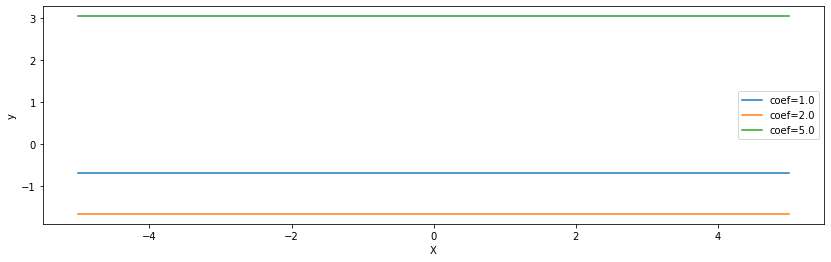

In [13]:
plt.figure(figsize=(14, 4))
[plt.plot(x, samples[0, i, :], label=f"coef={coefs[i]}") for i in range(3)]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

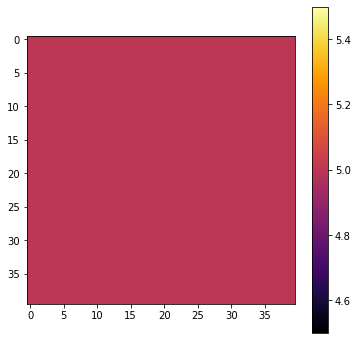

In [14]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

coef = 5.0
k = Constant(coef=coef, ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

### White Noise Kernel

This kernel adds some noise to the covariance functions and is mostly
used to stabilize other PSD kernels. This helps them become non-singular
and makes cholesky decomposition possible for sampling from the
``MvNormalCholesky`` distribution. It is recommended to use this kernel in
combination with other covariance/kernel function when working with GP on
large data.


$$
X(x_i, x_j) =
\begin{cases}
  \eta,    &   i = j \\
  0,       &   \text{otherwise}
\end{cases}
$$

where $\eta$ is 'noise level' or simply noise.

The signature of `WhiteNoise` kernel implemented in `pymc4` is:

```python
k = WhiteNoise(noise, feature_ndims=1., active_dims=None, scale_diag=None)
```

In [15]:
noises = [0.1, 0.9, 2.1]

k = WhiteNoise(noise=noises, ARD=False)

In [16]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-6)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

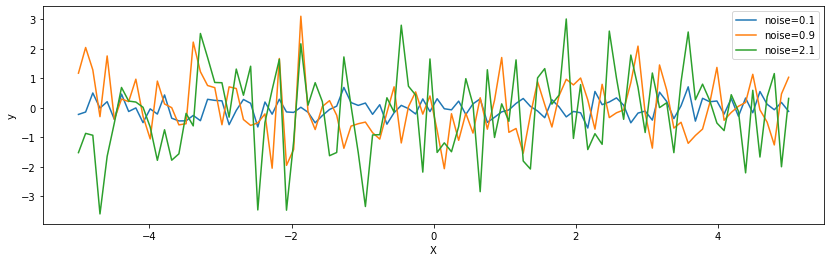

In [17]:
plt.figure(figsize=(14, 4))
[plt.plot(x, samples[0, i, :], label=f"noise={noises[i]}") for i in range(3)]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

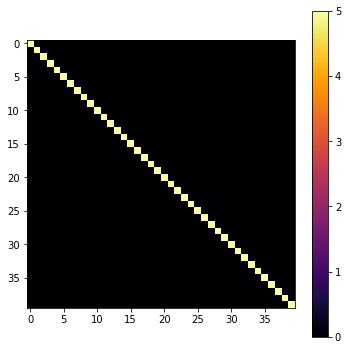

In [18]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

noise = 5.0
k = WhiteNoise(noise=noise, ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

### Exponentail Quadratic Kernel

This is the most used kernel in GP Modelling because of its nice properties. It is numerically very stable and infinitely differentiable. It comes from Squared Exponential (SE) family of kernels which is also commonly called as the Radial Basis Kernel Family.

It's mathematical expression is:

$$k(x, x') = \sigma^2 \exp\left( \frac{\|x-x'\|^2}{2\ell^2} \right)$$

where $\sigma$ is called "amplitude" and $\ell$ is called "length scale" of the kernel.

Amplitude controls how many units away the covariance is from the mean and length scale controls the 'wiggles' in the covariance matrix. In general, you won't be able to extrapolate more than ℓ units away from your data. If a float, an isotropic kernel is used. If an array and ``ARD=True``, an anisotropic kernel is used where each dimension defines the length-scale of the respective feature dimension.

The signature of Exponential Quadratic kernel implemented in `pymc4` is:

```python
k = ExpQuad(length_scale=1., amplitude=1., feature_ndims=1, active_dims=None, scale_diag=None)
```

In [19]:
# We are using tf.float64 for better numerical accuracy.
length_scales = tf.constant([0.5, 0.8, 1.2], dtype=tf.float64)
amplitudes = tf.constant([1.0, 2.0, 5.0], dtype=tf.float64)

k = ExpQuad(length_scale=length_scales, amplitude=amplitudes, ARD=False)

In [20]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

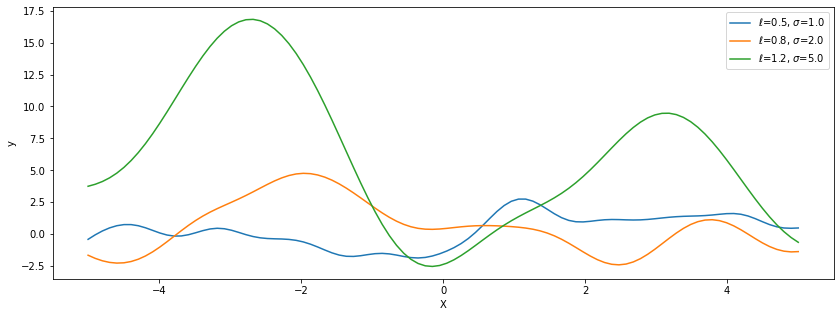

In [21]:
plt.figure(figsize=(14, 5))
[
    plt.plot(
        x,
        samples[0, i, :],
        label=f"$\\ell$={length_scales[i]}, $\\sigma$={amplitudes[i]}",
    )
    for i in range(3)
]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

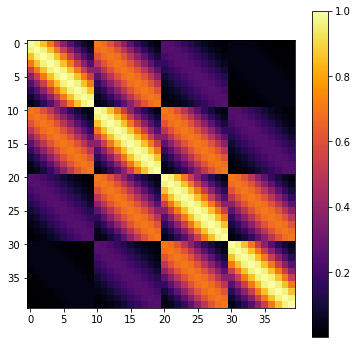

In [22]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

ls, amp = 0.8, 1.0
k = ExpQuad(length_scale=ls, amplitude=amp, ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

### Rational Quadratic Kernel

Rational Quadratic Kernel is a generalization over the Exponential Quadratic Kernel. It is equivalent to using a combination of Exponential Quadratic kernel with different length scales. One extra parameter $\alpha$ controls the "*mixture rate*" of the kernel and is also known as "scale mixture rate". As this parameter approaches infinity, the kernel becomes exactly equivalent to the Exponential Quadratic Kernel. The mathematical formula for the kernel is given by:

$$k(x,x') = \sigma^2 \left( 1 + \frac{\|x-x'\|^2}{2\alpha\ell^2} \right)^\alpha$$

where $\sigma$ is the amplitude, $\ell$ is the length scale, and $\alpha$ is the scale mixture rate.

The signature of the kernel implemented in `pymc4` is:

```python
k = RatQuad(length_scale, amplitude=1., scale_mixture_rate=1., feature_ndims=1, active_dims=None, scale_diag=None)
```

In [23]:
length_scales = tf.constant(0.8, dtype=tf.float64)
amplitudes = tf.constant(1.0, dtype=tf.float64)
scale_mixture_rates = tf.constant([1.0, 5.0, 10000.0], dtype=tf.float64)

k = RatQuad(
    length_scale=length_scales,
    amplitude=amplitudes,
    scale_mixture_rate=scale_mixture_rates,
    ARD=False,
)

In [24]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

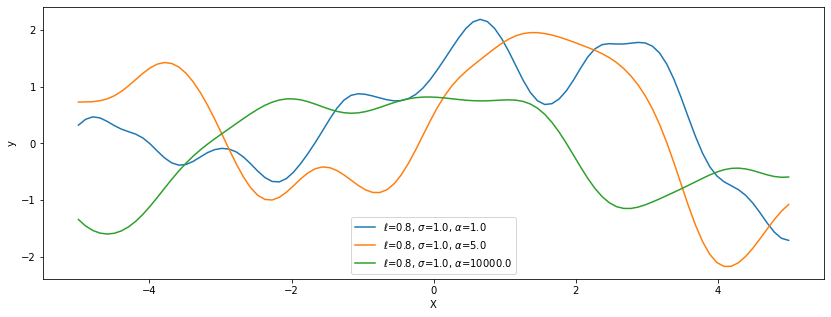

In [25]:
plt.figure(figsize=(14, 5))
[
    plt.plot(
        x,
        samples[0, i, :],
        label=f"$\\ell$={length_scales}, "
        f"$\\sigma$={amplitudes}, "
        f"$\\alpha$={scale_mixture_rates[i]}",
    )
    for i in range(3)
]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

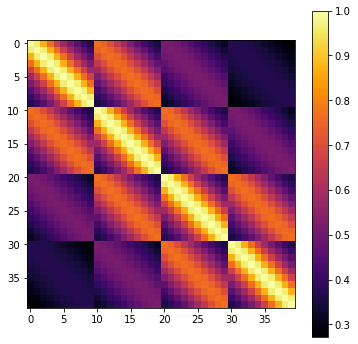

In [26]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

ls, amp, alpha = 0.8, 1.0, 0.5
k = RatQuad(length_scale=ls, amplitude=amp, scale_mixture_rate=alpha, ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

### Matern Family of Kernels

Matern family of kernels is a generalization over the RBF family of kernels. The $\nu$ parameter controls the smoothness of the kernel function. Higher values of $\nu$ result in smoother functions. The most common values of $\nu$ are 0.5, 1.5 and 2.5 as the modified Bessel's function is analytical there. The full mathematical formula of matern kernels is given by:

$$k(x_i, x_j) =  \frac{1}{\Gamma(\nu)2^{\nu-1}}\Bigg(
\frac{\sqrt{2\nu}}{l} d(x_i , x_j )
\Bigg)^\nu K_\nu\Bigg(
\frac{\sqrt{2\nu}}{l} d(x_i , x_j )\Bigg)$$

where $d(.)$ is the Euclidean distance, $K_\nu(.)$ is a modified Bessel function and $\Gamma(.)$ is the gamma function.

For other values of $\nu$, the computational cost to evaluate the kernel is extreamly high and so isn't implemented in `pymc4`.

Let's see the kernels we get for some special values of $\nu$

### Matern 1/2 Kernel

This kernel has the value of $\nu = 0.5$ It can be analytically shown as:

$$k(x, x') = \sigma^2\mathrm{exp}\left( -\frac{\|x - x'\|^2}{\ell} \right)$$

It's signature in `pymc4` is:

```python
k = Matern12(length_scale, amplitude=1., feature_ndims=1, active_dims=None, scale_diag=None)
```

In [27]:
length_scales = tf.constant([0.8, 1.2, 2.5], dtype=tf.float64)
amplitudes = tf.constant([1.0, 5.0, 10.0], dtype=tf.float64)

k = Matern12(length_scale=length_scales, amplitude=amplitudes, ARD=False)

In [28]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

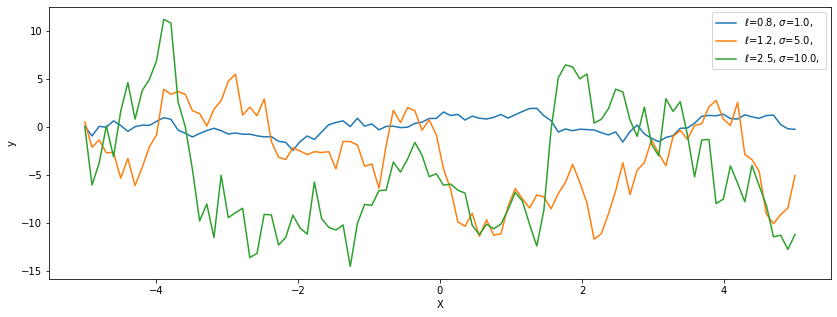

In [29]:
plt.figure(figsize=(14, 5))
[
    plt.plot(
        x,
        samples[0, i, :],
        label=f"$\\ell$={length_scales[i]}, " f"$\\sigma$={amplitudes[i]}, ",
    )
    for i in range(3)
]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

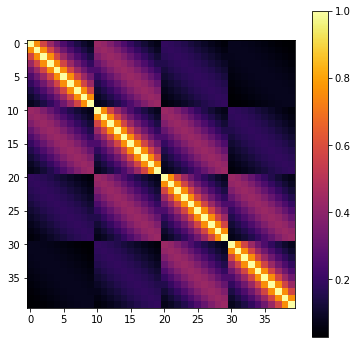

In [30]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

ls, amp = 0.8, 1.0
k = Matern12(length_scale=ls, amplitude=amp, ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

### Matern 3/2 Kernel

This kernel has the value of $\nu = 1.5$ It can be analytically shown as:

$$k(x, x') = \left(1 + \frac{\sqrt{3(x - x')^2}}{\ell}\right)
                   \mathrm{exp}\left( - \frac{\sqrt{3(x - x')^2}}{\ell} \right)$$

It's signature in `pymc4` is:

```python
k = Matern32(length_scale, amplitude=1., feature_ndims=1, active_dims=None, scale_diag=None)
```

In [31]:
length_scales = tf.constant([0.8, 1.2, 2.5], dtype=tf.float64)
amplitudes = tf.constant([1.0, 5.0, 10.0], dtype=tf.float64)

k = Matern32(length_scale=length_scales, amplitude=amplitudes, ARD=False)

In [32]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

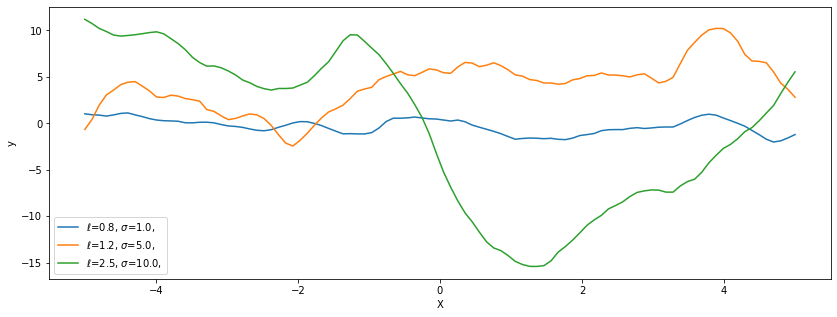

In [33]:
plt.figure(figsize=(14, 5))
[
    plt.plot(
        x,
        samples[0, i, :],
        label=f"$\\ell$={length_scales[i]}, " f"$\\sigma$={amplitudes[i]}, ",
    )
    for i in range(3)
]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

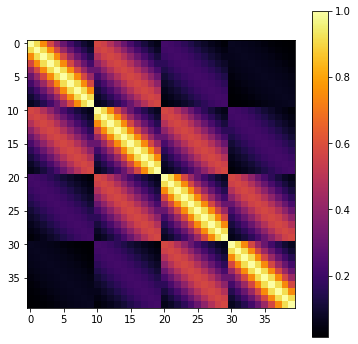

In [34]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

ls, amp = 0.8, 1.0
k = Matern32(length_scale=ls, amplitude=amp, ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

### Matern 5/2 Kernel

This kernel has the value of $\nu = 2.5$ It can be analytically shown as:

$$k(x, x') = \left(1 + \frac{\sqrt{5(x - x')^2}}{\ell} +
                   \frac{5(x-x')^2}{3\ell^2}\right)
                   \mathrm{exp}\left[ - \frac{\sqrt{5(x - x')^2}}{\ell} \right]$$

It's signature in `pymc4` is:

```python
k = Matern52(length_scale, amplitude=1., feature_ndims=1, active_dims=None, scale_diag=None)
```

In [35]:
length_scales = tf.constant([0.8, 1.2, 2.5], dtype=tf.float64)
amplitudes = tf.constant([1.0, 5.0, 10.0], dtype=tf.float64)

k = Matern52(length_scale=length_scales, amplitude=amplitudes, ARD=False)

In [36]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

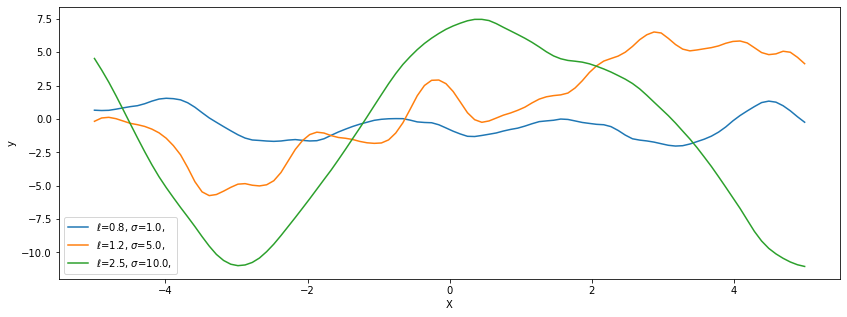

In [37]:
plt.figure(figsize=(14, 5))
[
    plt.plot(
        x,
        samples[0, i, :],
        label=f"$\\ell$={length_scales[i]}, " f"$\\sigma$={amplitudes[i]}, ",
    )
    for i in range(3)
]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

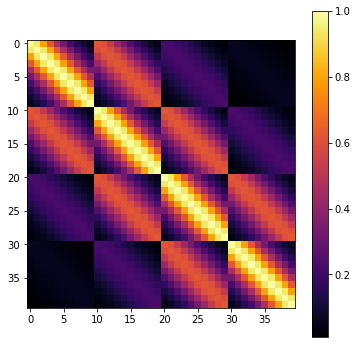

In [38]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

ls, amp = 0.8, 1.0
k = Matern52(length_scale=ls, amplitude=amp, ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

### Linear Kernel

This kernel evaluates a linear function of the inputs $x$ and $x'$. This means it is performing Bayesian Linear Regression in $\mathcal{O}(n)$ time. Parameter $\sigma_b$ comtrols how far the covariance is from the mean value and is called "bias variance". $\sigma_v$ controls how fast the covariance grows with respect to the origin point and is called "slope variance". $c$ is the shift parameter which shift points closer to the origin by $c$ units.

$$k(x, x') = \sigma_b^2 + \sigma_v^2\left(x - c\right)\left(x'-c\right)$$

where $\sigma_b$ is bias variance, $\sigma_v$ is slope variance,
and $c$ is the shift parameter.

It's signature in `pymc4` is:

```python
k = Linear(bias_variance, slope_variance, shift, feature_ndims=1, active_dims=None, scale_diag=None)
```

In [39]:
bias_variances = tf.constant([1.0, 5.0, 10.0], dtype=tf.float64)
slope_variances = tf.constant([1.0, 2.0, 5.0], dtype=tf.float64)
shifts = tf.constant([0.0, 10.0, 50.0], dtype=tf.float64)

k = Linear(
    bias_variance=bias_variances,
    slope_variance=slope_variances,
    shift=shifts,
    ARD=False,
)

In [40]:
x = np.linspace(0.0, 100.0, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

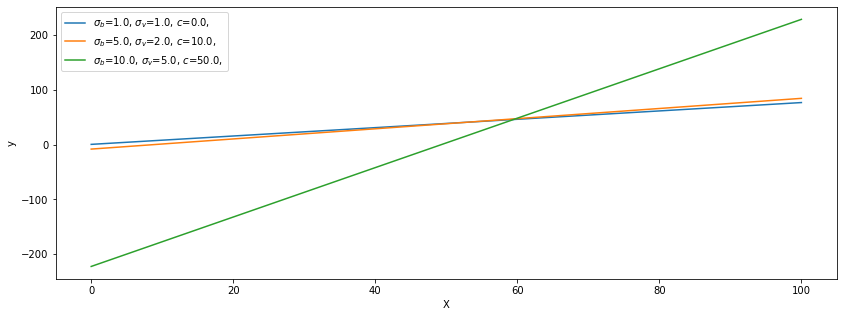

In [41]:
plt.figure(figsize=(14, 5))
[
    plt.plot(
        x,
        samples[0, i, :],
        label=f"$\\sigma_b$={bias_variances[i]}, "
        f"$\\sigma_v$={slope_variances[i]}, "
        f"$c$={shifts[i]}, ",
    )
    for i in range(3)
]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

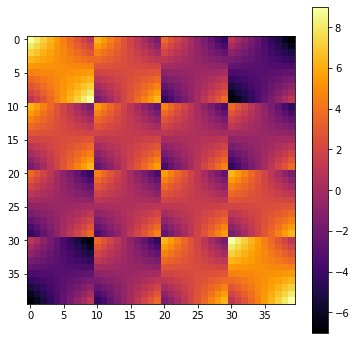

In [42]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

bv, sv, c = 1.0, 2.0, 0.0
k = Linear(bias_variance=bv, slope_variance=sv, shift=c, ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

### Polynomial Kernel

This kernel is a generalization over the Linear Kernel and performs polynomial regression on the data to evaluate the covariance matrix. An extra parameter $\alpha$ controls the degree of the polynomial. This kernel is exactly the same as the Linear Kernel when $\alpha=1$.

This kernel can be represented mathematically as:

$$k(x,x') = \sigma_b^2 + \sigma_v^2\left((x-c)(x'-c)\right)^\alpha$$

where $\sigma_b$ and $\sigma_v$ are the same as before and $\alpha$ is the exponent.

It's signature in `pymc4` is:

```python
k = Polynomial(bias_variance, slope_variance, shift, exponent, feature_ndims=1, active_dims=None, scale_diag=None)
```

In [43]:
bias_variances = tf.constant(1.0, dtype=tf.float64)
slope_variances = tf.constant(2.0, dtype=tf.float64)
shifts = tf.constant(0.0, dtype=tf.float64)
exponents = tf.constant([1.0, 2.0, 3.0], dtype=tf.float64)

k = Polynomial(
    bias_variance=bias_variances,
    slope_variance=slope_variances,
    shift=shifts,
    exponent=exponents,
    ARD=False,
)

In [44]:
x = np.linspace(-10.0, 10.0, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

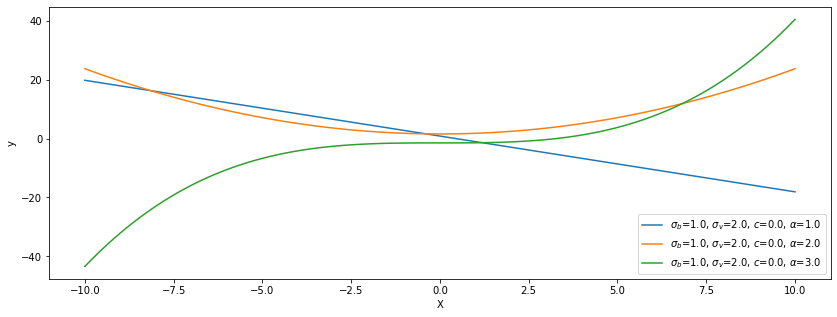

In [45]:
plt.figure(figsize=(14, 5))
[
    plt.plot(
        x,
        samples[0, i, :],
        label=f"$\\sigma_b$={bias_variances}, "
        f"$\\sigma_v$={slope_variances}, "
        f"$c$={shifts}, "
        f"$\\alpha$={exponents[i]}",
    )
    for i in range(3)
]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

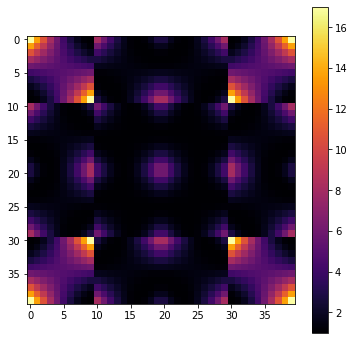

In [46]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

bv, sv, c, e = 1.0, 2.0, 0.0, 2.0
k = Polynomial(bias_variance=bv, slope_variance=sv, shift=c, exponent=e, ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

### Exponential Kernel

This kernel is an alternative to ExpQuad kernel. It works in a similar manner. It's mathematical formula can be given as:

$$k(x,x') = \sigma^2 \mathrm{exp}\left( -\frac{||x - x'||}{2\ell^2} \right)$$

The subtle difference between the two is that the norm ($\|.\|$) term isn't squared in this kernel.

The signature of this kernel is:

```python
k = Exponential(length_scale, amplitude=1., feature_ndims=1, active_dims=None, scale_diag=None)
```

In [47]:
length_scales = tf.constant([0.5, 0.8, 1.2], dtype=tf.float64)
amplitudes = tf.constant([1.0, 2.0, 5.0], dtype=tf.float64)

k = Exponential(length_scale=length_scales, amplitude=amplitudes, ARD=False)

In [48]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

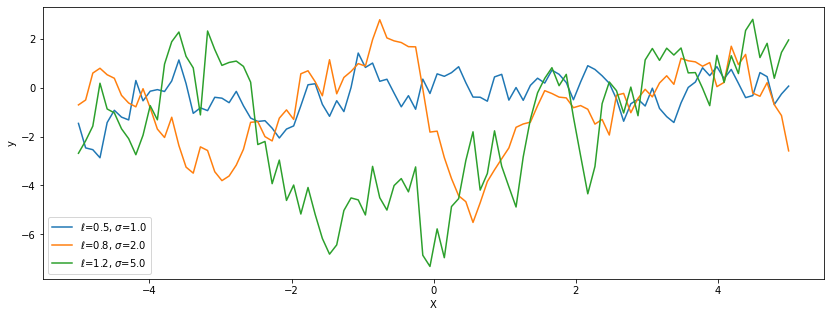

In [49]:
plt.figure(figsize=(14, 5))
[
    plt.plot(
        x,
        samples[0, i, :],
        label=f"$\\ell$={length_scales[i]}, $\\sigma$={amplitudes[i]}",
    )
    for i in range(3)
]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

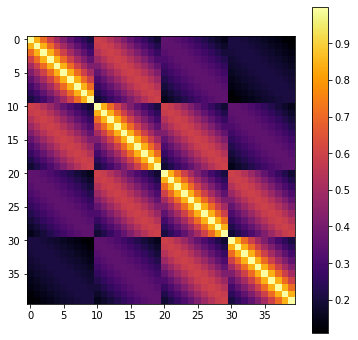

In [50]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

ls, amp = 0.8, 1.0
k = Exponential(length_scale=ls, amplitude=amp, ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

## Periodic Kernels in PyMC4!

A total of 2 periodic kernels have been implemented in PyMC4.

- [Exponential Sine Squared Kernel](#Exponential-Sine-Squared-Kernel)
- [Cosine Kernel](#Cosine-Kernel)

### Exponential Sine Squared Kernel

Periodic kernel aka Exponential Sine Squared Kernel comes from Periodic Family of kernels. This kernels occilates in space with a period $T$ as a function of the $\sin$ wave. This kernel is used mostly for time-series and other temporal prediction tasks. It can be expressed as:

$$k(x, x') = \sigma^2 \exp\left(-\frac{2\sin^2\left(\frac{\pi\|x-x'\|^2}
           {T}\right)}{\ell^2}\right)$$
           
where $T$ is period of the kernel.

It's signature in PyMC4 is:

```python
k = Periodic(length_scale, amplitude=1., period=1., feature_ndims=1, active_dims=None, scale_diag=None)
```

In [51]:
length_scales = tf.constant(1.0, dtype=tf.float64)
amplitudes = tf.constant(1.0, dtype=tf.float64)
periods = tf.constant([1.0, 2.0, 3.0], dtype=tf.float64)

k = Periodic(
    length_scale=length_scales, amplitude=amplitudes, period=periods, ARD=False
)

In [52]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

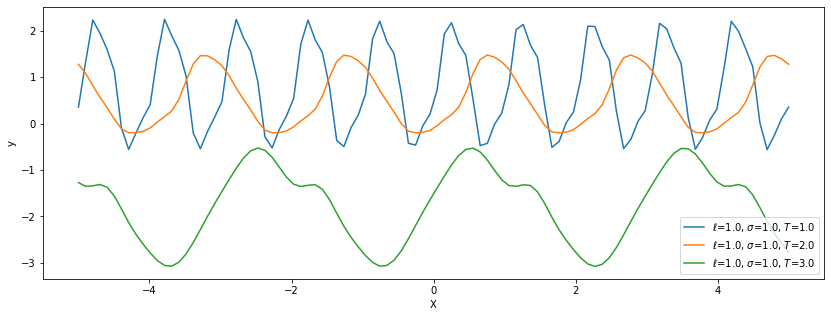

In [53]:
plt.figure(figsize=(14, 5))
[
    plt.plot(
        x,
        samples[0, i, :],
        label=f"$\ell$={length_scales}, "
        f"$\sigma$={amplitudes}, "
        f"$T$={periods[i]}",
    )
    for i in range(3)
]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

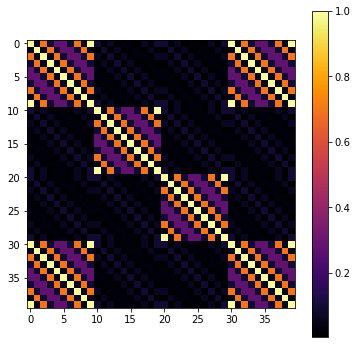

In [54]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

ls, amp, t = 0.8, 1.0, 0.5
k = Periodic(length_scale=ls, amplitude=amp, period=t, ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

### Cosine Kernel

This kernel is a part of the Periodic Kernels. It evaluates a cosine function to compute the covariance matrix. It can be shown mathematically as:

$$k(x,x') = \sigma^2\cos\left(\frac{2\pi\|x-x'\|^2}{\ell^2}\right)$$

It's signature in PyMC4 is:

```python
k = Cosine(length_scale, amplitude=1., feature_ndims=1, active_dims=None, scale_diag=None)
```

In [55]:
length_scales = tf.constant([0.8, 2.0, 5.0], dtype=tf.float64)
amplitudes = tf.constant([1.0, 5.0, 10.0], dtype=tf.float64)

k = Periodic(length_scale=length_scales, amplitude=amplitudes, ARD=False)

In [56]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

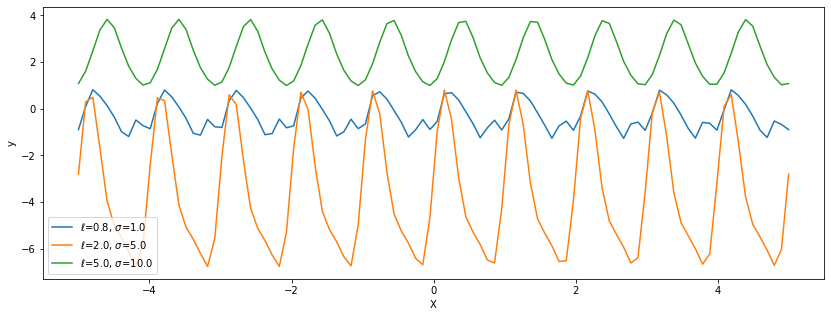

In [57]:
plt.figure(figsize=(14, 5))
[
    plt.plot(
        x,
        samples[0, i, :],
        label=f"$\ell$={length_scales[i]}, " f"$\sigma$={amplitudes[i]}",
    )
    for i in range(3)
]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

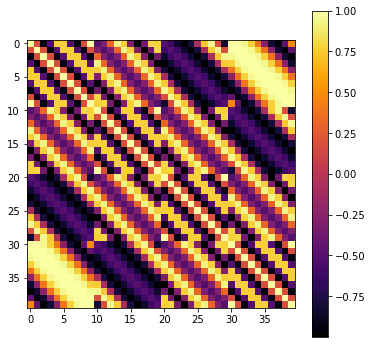

In [58]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

ls, amp = 1.0, 1.0
k = Cosine(length_scale=ls, amplitude=amp, ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

## Non-Stationary Kernels

There are a total of 3 non-stationary distributions in PyMC4. These kernels very not only with respect to the parameters but the position of data in space.

- [Gibbs Kernel](#Gibbs-Kernel)
- [Scaled Covariance Kernel](#Scaled-Covariance-Kernel)
- [Warped Input Kernel](#Warped-Input-Kernel)

### Gibbs Kernel

This kernel comes from a non-stationary family of kernels. The `length_scale` parameter varies with varying inputs. It is expressed as:

$$k(x, x') = \sqrt{\frac{2\ell(x)\ell(x')}{\ell^2(x) + \ell^2(x')}}
                   \mathrm{exp}\left( -\frac{\|x - x'\|^2}
                   {\ell^2(x) + \ell^2(x')} \right)$$
                   
where $\ell(.)$ is a function of inputs that outputs a different length scale for each of the input points.

The signature of this kernel in PyMC4 is

```python
k = Gibbs(length_scale_fn, fn_args, feature_ndims=1, active_dims=None, scale_diag=None)
```

This kernel expects `length_scale_fn` to have the following signature:

```python
def length_scale_fn(x: array_like, *fn_args) -> array_like:
    ...
```

The `array_like` type can be any type of array (numpy array, tensorflow tensor, etc) of the same shape as the input where each entry coresponds to the `length_scale` for that point.

#### Notes

This kernel is very slow and computationally heavy compared to other kernels. It works best with inputs having a single feature dimension and a single entry in that dimension. This means the inputs should have the shape ``(..., n, 1)`` and ``(..., m, 1)``. Other inputs will work but the evaluation will be very slow.

No argument validation is done even when `validate_args=True`.

In [59]:
def tanh_fn(x, ls1, ls2, w, x0):
    """
    ls1: left saturation value
    ls2: right saturation value
    w:   transition width
    x0:  transition location.
    """
    return (ls1 + ls2) / 2 - (ls1 - ls2) / 2 * tf.tanh((x - x0) / w)


ls1 = tf.constant(0.05, dtype=tf.float64)
ls2 = tf.constant(0.6, dtype=tf.float64)
w = tf.constant(0.3, dtype=tf.float64)
x0 = tf.constant(1.0, dtype=tf.float64)
# You can also partial the length_scale function to avoid passing extra argumets.
# from functools import partial
# fn = partial(tanh_fn, ls1=ls1, ls2=ls2, w=w, x0=x0)
k = Gibbs(
    length_scale_fn=tanh_fn, fn_args=(ls1, ls2, w, x0), dtype=tf.float64, ARD=False
)

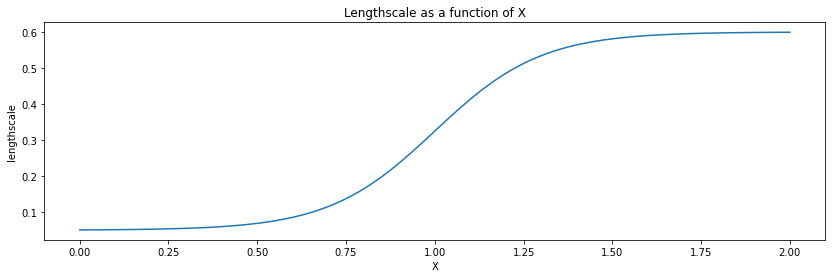

In [60]:
# Let's visualize the tanh function
x = np.linspace(0.0, 2.0, num=100)[:, np.newaxis]

wf = tanh_fn(x, ls1, ls2, w, x0)
plt.figure(figsize=(14, 4))
plt.plot(x, wf)
plt.ylabel("lengthscale")
plt.xlabel("X")
plt.title("Lengthscale as a function of X");

In [61]:
# Let's evaluate the covariance matrix.
covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0, covariance_matrix=covs)
samples = dists.sample(3)

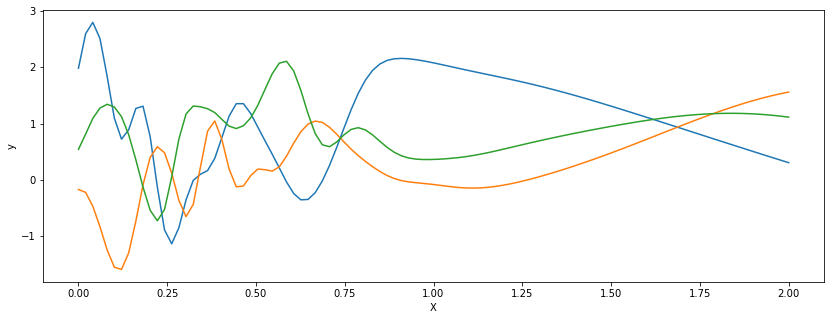

In [62]:
plt.figure(figsize=(14, 5))
[plt.plot(x, samples[i, :]) for i in range(3)]
plt.xlabel("X")
plt.ylabel("y")
plt.show()

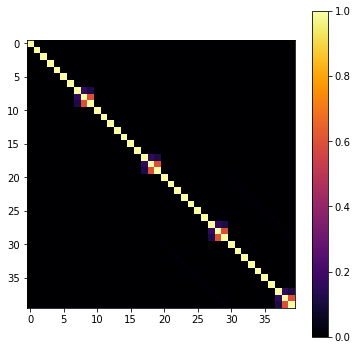

In [63]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

k = Gibbs(
    length_scale_fn=tanh_fn, fn_args=(ls1, ls2, w, x0), dtype=tf.float64, ARD=False
)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

### Scaled Covariance Kernel

This kernel uses a scaling function to scale the covariance between two points evaluated using some other kernel. This scaling function is a function of the inputs and returns a output of the same shape. It can be expressed as

$$k'(x,x') = f(x) k(x,x')$$

where $k(x,x')$ is the kernel function used to evaluate the covariance matrix and $f(.)$ is the scaling function.

It's signature in PyMC4 is

```python
k = ScaledCov(kernel, scaling_fn, fn_args=None)
```

This kernel expects the function `scaling_fn` to have a signature

```python
def scaling_fn(x: array_like, *fn_args) -> array_like:
    ...
```

It must return an array of the same shape as that of the input `x`.

#### Notes

This kernel doesn't perform argument validation even when `validate_args=True`.

In [64]:
def logistic(x, a, x0, c, d):
    # a is the slope, x0 is the location
    return d * tf.sigmoid(a * (x - x0)) + c


a = tf.constant(2.0, dtype=tf.float64)
x0 = tf.constant(5.0, dtype=tf.float64)
c = tf.constant(0.1, dtype=tf.float64)
d = tf.constant(2.0, dtype=tf.float64)

kernel = ExpQuad(tf.constant(0.2, dtype=tf.float64), ARD=False)
k = ScaledCov(kernel=kernel, scaling_fn=logistic, fn_args=(a, x0, c, d), ARD=False)

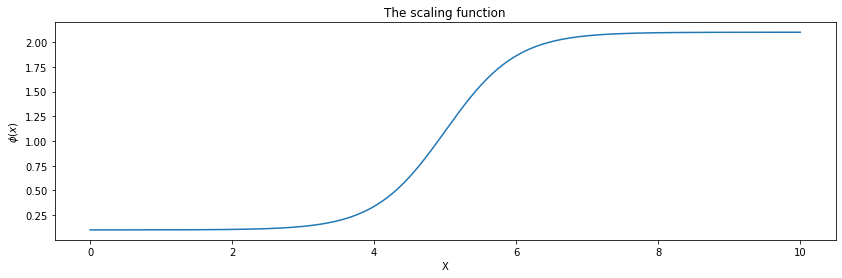

In [65]:
# Let's visualize the logistic function.
x = np.linspace(0, 10, 400)[:, None]
lfunc = logistic(x, a, x0, c, d)

plt.figure(figsize=(14, 4))
plt.plot(x, lfunc)
plt.xlabel("X")
plt.ylabel("$\phi(x)$")
plt.title("The scaling function");

In [66]:
# Let's evaluate the covariance matrix.
covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0, covariance_matrix=covs)
samples = dists.sample(3)

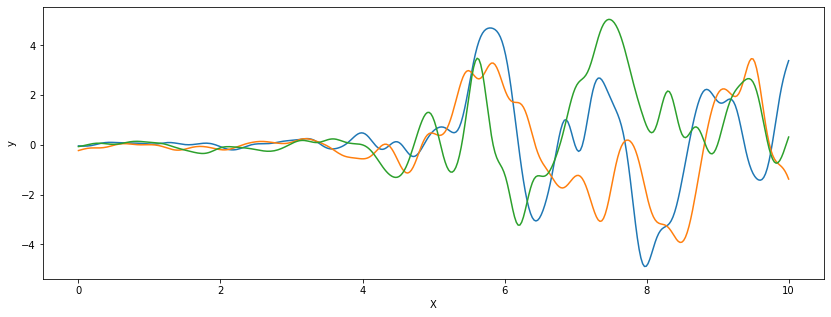

In [67]:
plt.figure(figsize=(14, 5))
[plt.plot(x, samples[i, :]) for i in range(3)]
plt.xlabel("X")
plt.ylabel("y")
plt.show()

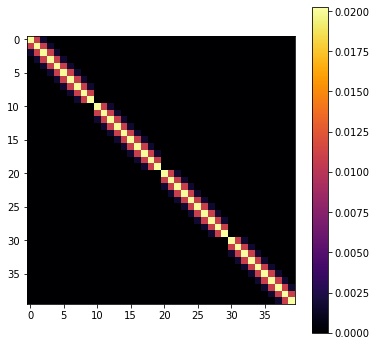

In [68]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

kernel = ExpQuad(tf.constant(0.2, dtype=tf.float64), ARD=False)
k = ScaledCov(kernel=kernel, scaling_fn=logistic, fn_args=(a, x0, c, d), ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

### Warped Input Kernel

This kernel transforms the input using a transformation function and uses it instead to evaluate the covariance matrix. This is also called `FeatureTransformed` kernel. It's mathematical form is

$$k'(x,x') = k(f(x), f(x'))$$

where $f(.)$ is a warping (transformation) function.

Its signature in PyMC4 is

```python
k = WarpedInput(kernel, warp_fn, fn_args=None)
```

It expects the signature of function `warp_fn` to be:

```python
def warp_fn(x: array_like, *fn_args) -> array_like:
    ...
```

Below is the example of constructing a `Periodic` kernel using warped input kernel!

#### Notes

This kernel doesn't perform argument validation even if `validate_args=True`.

In [69]:
def mapping(x, T):
    c = 2.0 * np.pi * (1.0 / T)
    u = tf.concat((tf.math.sin(c * x), tf.math.cos(c * x)), axis=1)
    return u


T = tf.constant(0.6, dtype=tf.float64)
ls = tf.constant(0.4, dtype=tf.float64)

kernel = ExpQuad(ls, ARD=False)
k = WarpedInput(kernel=kernel, warp_fn=mapping, fn_args=(T,), ARD=False)

In [70]:
x = np.linspace(0, 2, 400)[:, None]
covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0, covariance_matrix=covs)
samples = dists.sample(3)

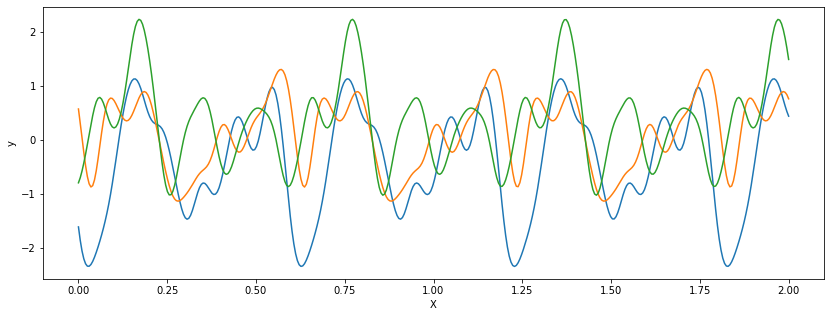

In [71]:
plt.figure(figsize=(14, 5))
[plt.plot(x, samples[i, :]) for i in range(3)]
plt.xlabel("X")
plt.ylabel("y")
plt.show()

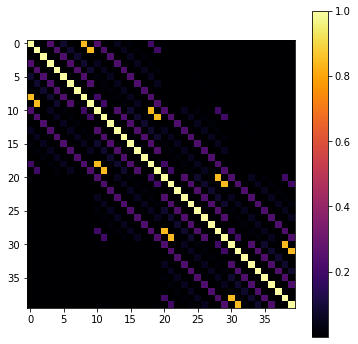

In [72]:
x1, x2 = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 4))
X2 = np.concatenate((x1.reshape(40, 1), x2.reshape(40, 1)), axis=1)

kernel = ExpQuad(ls, ARD=False)
k = WarpedInput(kernel=kernel, warp_fn=mapping, fn_args=(T,), ARD=False)

cov = k(X2, X2)
plt.figure(figsize=(6, 6))
m = plt.imshow(cov, cmap="inferno", interpolation="none")
plt.colorbar(m);

## Combination of Kernel

PyMC4 allows combination of kernels to generate new kernels. This can be very helpful to construct new kernels that aren't directly imlemented in PyMC4. This includes

- [Locally Periodic Kernel.](#Locally-Periodic-Kernel)
- [Changepoint Kernel.](#Changepoint-Kernel)

This section show the use of both addition and multiplication on kernels.

### Locally Periodic Kernel

Locally Periodic kernel is a product of the `ExpQuad` and periodic kernel. Its mathematical formula is

$$k_{\textrm{LocalPer}}(x, x') = k_{\textrm{Per}}(x, x')k_{\textrm{SE}}(x, x') = \sigma^2\exp\left(-\frac{2\sin^2(\frac{\pi|x - x'|}{T})}{\ell^2}\right) \exp\left(-\frac{(x - x')^2}{2\ell^2}\right)$$

It can be impemented in PyMC4 using the product `*` operator.

```python
k = ExpQuad(length_scale, amplitude, ...) * Periodic(length_scale, amplitude, period, ...)
```

This new kernel `k` is another covariance function and has all the methods like other covariance functions.

In [73]:
ls_eq = tf.constant([0.8, 1.2, 2.2], dtype=tf.float64)
amp_eq = tf.constant([1.0, 5.0, 10.0], dtype=tf.float64)

k1 = ExpQuad(length_scale=ls_eq, amplitude=amp_eq)

ls_p = tf.constant(1.0, dtype=tf.float64)
amp_p = tf.constant(1.0, dtype=tf.float64)
period = tf.constant([0.5, 1.0, 2.0], dtype=tf.float64)

k2 = Periodic(length_scale=ls_p, amplitude=amp_p, period=period)

k = k1 * k2

In [74]:
x = np.linspace(-5, 5, num=100)[:, np.newaxis]

covs = stabilize(k(x, x), shift=1e-8)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(1)

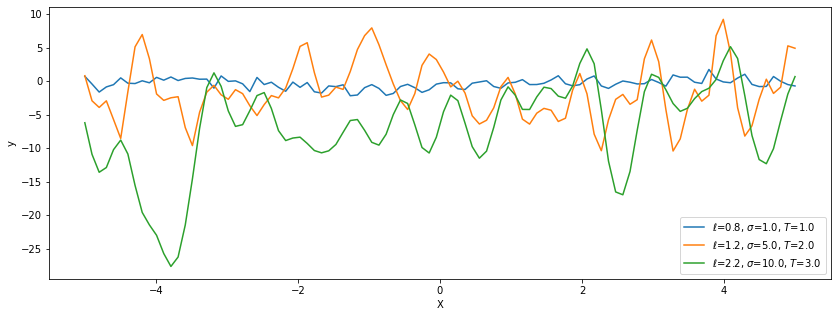

In [75]:
plt.figure(figsize=(14, 5))
[
    plt.plot(
        x,
        samples[0, i, :],
        label=f"$\ell$={ls_eq[i]}, " f"$\sigma$={amp_eq[i]}, " f"$T$={periods[i]}",
    )
    for i in range(3)
]
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

### Changepoint Kernel

The `ScaledCov` kernel can be used to create the `Changepoint` covariance. This covariance models a process that gradually transitions from one type of behavior to another.

The changepoint kernel is given by

$$k(x,x') = \phi(x)k_1(x,x')\phi(x') + (1-\phi(x))k_2(x,x')(1-\phi(x'))$$

In [76]:
def logistic(x, a, x0):
    # a is the slope, x0 is the location
    return tf.sigmoid(a * (x - x0))


a = tf.constant(2.0, dtype=tf.float64)
x0 = tf.constant(5.0, dtype=tf.float64)

k1 = ScaledCov(kernel=ExpQuad(np.array(0.2)), scaling_fn=logistic, fn_args=(-a, x0))
k2 = ScaledCov(kernel=Cosine(np.array(0.5)), scaling_fn=logistic, fn_args=(a, x0))
k = k1 + k2

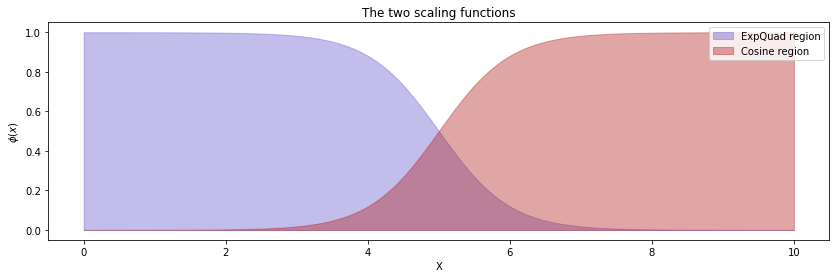

In [77]:
x = np.linspace(0, 10, 400)
plt.figure(figsize=(14, 4))
plt.fill_between(
    x,
    np.zeros(400),
    logistic(x, -a, x0),
    label="ExpQuad region",
    color="slateblue",
    alpha=0.4,
)
plt.fill_between(
    x,
    np.zeros(400),
    logistic(x, a, x0),
    label="Cosine region",
    color="firebrick",
    alpha=0.4,
)
plt.legend()
plt.xlabel("X")
plt.ylabel("$\phi(x)$")
plt.title("The two scaling functions");

In [78]:
covs = stabilize(k(x[:, None], x[:, None]), shift=1e-8)
dists = pm.MvNormal("_", loc=0.0, covariance_matrix=covs)
samples = dists.sample(3)

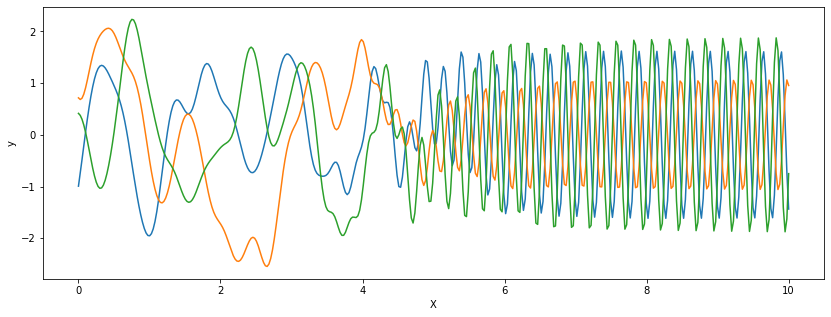

In [79]:
plt.figure(figsize=(14, 5))
[plt.plot(x, samples[i, :]) for i in range(3)]
plt.xlabel("X")
plt.ylabel("y")
plt.show()

## References

- [SciKit-Learn Matern Kernels Documentation][1]
- [The Kernel Cookbook by David Duvenaud][2]
- [PyMC3's GP submodule][3]

[1]: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html
[2]: https://www.cs.toronto.edu/~duvenaud/cookbook/
[3]: https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/GP-MeansAndCovs.ipynb

In [80]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy      1.18.5
tensorflow 2.3.0-dev20200608
arviz      0.8.3
pymc4      4.0a2
last updated: Wed Jun 24 2020 

CPython 3.7.3
IPython 7.15.0
watermark 2.0.2
